In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit,njit, prange, types

In [2]:
train = pd.read_csv('train.csv')
train.shape 

(600000, 25)

In [3]:
train.columns

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'target'],
      dtype='object')

In [4]:
test = pd.read_csv('test.csv')
test.shape 

(400000, 24)

In [5]:
train.nunique(dropna=False)

id        600000
bin_0          3
bin_1          3
bin_2          3
bin_3          3
bin_4          3
nom_0          4
nom_1          7
nom_2          7
nom_3          7
nom_4          5
nom_5       1221
nom_6       1520
nom_7        223
nom_8        223
nom_9       2219
ord_0          4
ord_1          6
ord_2          7
ord_3         16
ord_4         27
ord_5        191
day            8
month         13
target         2
dtype: int64

In [6]:
test.nunique(dropna=False)

id       400000
bin_0         3
bin_1         3
bin_2         3
bin_3         3
bin_4         3
nom_0         4
nom_1         7
nom_2         7
nom_3         7
nom_4         5
nom_5      1220
nom_6      1518
nom_7       223
nom_8       223
nom_9      2217
ord_0         4
ord_1         6
ord_2         7
ord_3        16
ord_4        27
ord_5       191
day           8
month        13
dtype: int64

In [7]:
train.isnull().sum(axis=0)

id            0
bin_0     17894
bin_1     18003
bin_2     17930
bin_3     18014
bin_4     18047
nom_0     18252
nom_1     18156
nom_2     18035
nom_3     18121
nom_4     18035
nom_5     17778
nom_6     18131
nom_7     18003
nom_8     17755
nom_9     18073
ord_0     18288
ord_1     18041
ord_2     18075
ord_3     17916
ord_4     17930
ord_5     17713
day       17952
month     17988
target        0
dtype: int64

In [8]:
test.isnull().sum(axis=0)

id           0
bin_0    11901
bin_1    12038
bin_2    11972
bin_3    11951
bin_4    11951
nom_0    12062
nom_1    11947
nom_2    12179
nom_3    12176
nom_4    11993
nom_5    11912
nom_6    12012
nom_7    12003
nom_8    11956
nom_9    12060
ord_0    11893
ord_1    12167
ord_2    12105
ord_3    12053
ord_4    11933
ord_5    12047
day      12025
month    11984
dtype: int64

In [9]:
train['isnan']=train.isnull().sum(axis=1)
test['isnan']=test.isnull().sum(axis=1)

In [10]:
train = train.fillna('nan')
test = test.fillna('nan')

In [11]:
"""

def split_0(x):
    x = str(x)
    if x=='nan':
        return x
    return x[:3]

def split_1(x):
    x = str(x)
    if len(x)<6:
        return 'nan'
    return x[3:6]

def split_2(x):
    x = str(x)
    if len(x)<9:
        return 'nan'
    return x[6:9]
    
nom_features = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
print(len(np.unique(train[nom_features].values.astype(str).flatten())))

uniq = []
nom_nom = []
nom_features = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
for feature in nom_features:

    train[feature+'_0']=train[feature].apply(lambda x: split_0(x))
    train[feature+'_1']=train[feature].apply(lambda x: split_1(x))
    train[feature+'_2']=train[feature].apply(lambda x: split_2(x))
    
    
    test[feature+'_0']=test[feature].apply(lambda x: split_0(x))
    test[feature+'_1']=test[feature].apply(lambda x: split_1(x))
    test[feature+'_2']=test[feature].apply(lambda x: split_2(x))
    
    nom_nom.append(feature+'_0')
    nom_nom.append(feature+'_1')
    nom_nom.append(feature+'_2')
    
"""

"\n\ndef split_0(x):\n    x = str(x)\n    if x=='nan':\n        return x\n    return x[:3]\n\ndef split_1(x):\n    x = str(x)\n    if len(x)<6:\n        return 'nan'\n    return x[3:6]\n\ndef split_2(x):\n    x = str(x)\n    if len(x)<9:\n        return 'nan'\n    return x[6:9]\n    \nnom_features = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']\nprint(len(np.unique(train[nom_features].values.astype(str).flatten())))\n\nuniq = []\nnom_nom = []\nnom_features = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']\nfor feature in nom_features:\n\n    train[feature+'_0']=train[feature].apply(lambda x: split_0(x))\n    train[feature+'_1']=train[feature].apply(lambda x: split_1(x))\n    train[feature+'_2']=train[feature].apply(lambda x: split_2(x))\n    \n    \n    test[feature+'_0']=test[feature].apply(lambda x: split_0(x))\n    test[feature+'_1']=test[feature].apply(lambda x: split_1(x))\n    test[feature+'_2']=test[feature].apply(lambda x: split_2(x))\n    \n    nom_nom.append(feature+'_0')\n    

In [12]:
"""
Parallel processing will be used to apply a mean-value encoding rank transform to features in the pandas dataframe.

This is accomplished by parallelizing the dataframe across the cores and applying map-reduce to transform the columns.

"""


import numpy
import ipyparallel as ipp
from ipyparallel import Client
rc = Client(profile='default')
dview = rc[:]
dview.block = True


# rc.debug = True
with dview.sync_imports():
    import numpy
    import gc
    
    
dview.execute('np=numpy')
dview.execute('np.mkl.set_num_threads(2)')

importing numpy on engine(s)
importing gc on engine(s)


<AsyncResult: execute:finished>

In [13]:
ids = dview.targets

num_cores = len(ids)

ids

[0, 1, 2, 3, 4, 5]

In [14]:
def distribute_df(df):
    df_split = np.array_split(df, num_cores, axis=0)

    for i in dview.targets:
        rc[i]['df'] = df_split[i]

    rdf = [ipp.Reference('df') for i in range(num_cores)]
    return rdf

In [15]:
def map_category_rank(df):
    return df[[feature,'target']].groupby(feature).agg(['sum','count'])    

def reduce_category_rank(x):
    y = pd.concat(x).groupby(level=0).sum()
    y.columns = y.columns.droplevel()
    y['mean'] = y['sum']/y['count']
    return y[['mean']]

def map_unique(df):
    return df[feature].unique().astype(str)

def reduce_unique(x):
    return np.unique(np.concatenate(x))

def map_missing_rank_transform(df):
    df[feature] = df[feature].astype(str).replace(new_category_mapper)
    
def map_rank_transform(df):
#     for key,value in mappers[feature].items():
    df[feature] = df[feature].astype(str).replace(mappers[feature])
    
    
class RankTransformParallel:
    def __init__( self,dview,ordinal=True):
        self.features = []
        self.mappers = {}
        self.dview = dview
        self.ids = dview.targets
        self.ordinal=ordinal
        
    
    def fit( self, rdf, features, target ):
        self.features = features

        for feature in self.features:
            self.dview['feature'] = feature
            _mapper_ = {}
            result=self.dview.map_sync(map_category_rank,rdf)
            result=reduce_category_rank(result)

            names = result.index.values.astype(str)
            
            if self.ordinal==True:
                values = np.argsort(result['mean'].values)
            else:
                values = result['mean'].values

            for n,v in zip(names,values):
                _mapper_[n] = v
                
            self.mappers[feature] = _mapper_

        self.dview['mappers'] = self.mappers
        return self 
    
    def transform( self, rdf, y = None ):
        
        for feature in self.features:

            self.dview['feature'] = feature

            result = self.dview.map_sync(map_unique,rdf)
            _uniq_ = reduce_unique(result)

            #if missing assign the median value
#             median_value = np.median(list(self.mappers[feature].values()))
#             new_category_mapper = {cat:median_value for cat in _uniq_ if cat not in self.mappers[feature].keys()}

            
            #if missing assign 0
            new_category_mapper = {cat:0 for cat in _uniq_ if cat not in self.mappers[feature].keys()}
            
            dview['new_category_mapper'] = new_category_mapper
            if len(new_category_mapper)>0:
                print(new_category_mapper)
                self.dview.map_sync(map_missing_rank_transform,rdf)
            
            self.dview.map_sync(map_rank_transform,rdf)

            
        return pd.concat(self.dview['df'])

In [16]:
features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 
       'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 
       'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5',
       'day', 'month','isnan']#+nom_nom

In [17]:
gc.collect()

47

In [18]:
rt = RankTransformParallel(dview)

rdf = distribute_df(train)

rt.fit(rdf,features=features,target='target')

train_rank = rt.transform(rdf)[features+['target','id']]

rdf = distribute_df(test)

test_rank = rt.transform(rdf)[features+['id']]

{'a885aacec': 0}


In [19]:
"""
import itertools
from collections import defaultdict
lkup = defaultdict(lambda: defaultdict(int))

groups = [
        ['nom_5_0','nom_6_0','nom_9_0'],
          ['nom_5_1','nom_6_1','nom_9_1'],
          ['nom_5_2','nom_6_2','nom_9_2'],
         ]

for group in groups:
    group = list(group)
    print(group)
    
    tmp=train_rank[group+['target']].groupby(group).agg(['sum','mean']) 
    tmp.columns = tmp.columns.droplevel()
    lkup[tuple(group)] = tmp[(tmp['mean']==1)&(tmp['sum']==1)].reset_index()[group]
    
    plt.plot(train_rank[group+['target']].groupby(group).mean().sort_values(by='target').values)
    plt.show()
    
train_leakage = []
test_leakage = []

for group in groups:

    trainleak = train_rank[group].apply(lambda x: np.any(np.all(x.values==lkup[tuple(group)].values,axis=1)),axis=1)
    testleak = test_rank[group].apply(lambda x: np.any(np.all(x.values==lkup[tuple(group)].values,axis=1)),axis=1)
    train_leakage.append(trainleak)
    test_leakage.append(testleak)
"""

"\nimport itertools\nfrom collections import defaultdict\nlkup = defaultdict(lambda: defaultdict(int))\n\ngroups = [\n        ['nom_5_0','nom_6_0','nom_9_0'],\n          ['nom_5_1','nom_6_1','nom_9_1'],\n          ['nom_5_2','nom_6_2','nom_9_2'],\n         ]\n\nfor group in groups:\n    group = list(group)\n    print(group)\n    \n    tmp=train_rank[group+['target']].groupby(group).agg(['sum','mean']) \n    tmp.columns = tmp.columns.droplevel()\n    lkup[tuple(group)] = tmp[(tmp['mean']==1)&(tmp['sum']==1)].reset_index()[group]\n    \n    plt.plot(train_rank[group+['target']].groupby(group).mean().sort_values(by='target').values)\n    plt.show()\n    \ntrain_leakage = []\ntest_leakage = []\n\nfor group in groups:\n\n    trainleak = train_rank[group].apply(lambda x: np.any(np.all(x.values==lkup[tuple(group)].values,axis=1)),axis=1)\n    testleak = test_rank[group].apply(lambda x: np.any(np.all(x.values==lkup[tuple(group)].values,axis=1)),axis=1)\n    train_leakage.append(trainleak)\n   

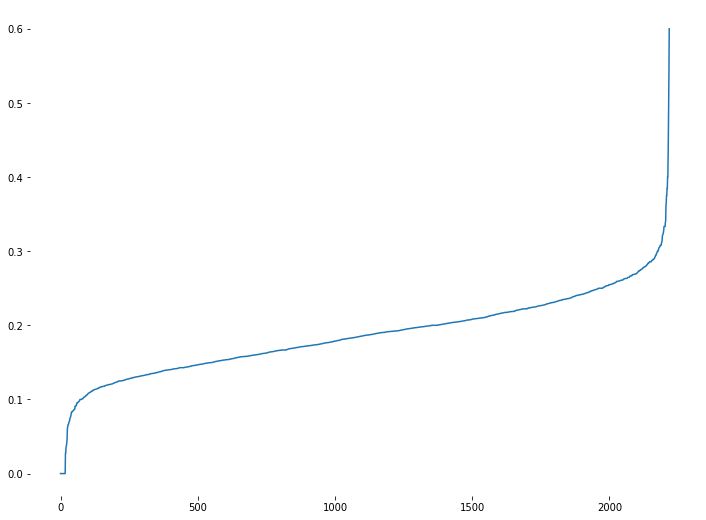

In [20]:
plt.figure(figsize=(12, 9))    
  
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.plot(train_rank[['nom_9','target']].groupby('nom_9').mean().sort_values(by='target').values)
plt.show()

In [21]:
binned_features = []
for f0 in ['nom_5','nom_6','nom_9']:
    
    bins = np.minimum(train_rank[f0].nunique(),256)
    
    XTRAIN = train_rank[f0].values.flatten().astype(np.float)
    XTEST = test_rank[f0].values.flatten().astype(np.float)

    #percentile based bins
    percentiles_bins = np.percentile(XTRAIN,
                                     np.linspace(0,100,bins))
    #bin limits based on the test data
#     _bins_ = np.linspace(np.min(XTRAIN),np.max(XTRAIN),bins)
    
    XTRAIN = np.digitize(XTRAIN,percentiles_bins)-1
    XTEST = np.digitize(XTEST,percentiles_bins)-1
    
    train_rank[f0+'_binned'] = XTRAIN
    test_rank[f0+'_binned'] = XTEST
    
    binned_features.append(f0+'_binned')
    
for f0 in ['nom_7','nom_8','ord_5']:
    
    bins = np.minimum(train_rank[f0].nunique(),128)
    
    XTRAIN = train_rank[f0].values.flatten().astype(np.float)
    XTEST = test_rank[f0].values.flatten().astype(np.float)

    #percentile based bins
    percentiles_bins = np.percentile(XTRAIN,
                                     np.linspace(0,100,bins))
    #bin limits based on the test data
#     _bins_ = np.linspace(np.min(XTRAIN),np.max(XTRAIN),bins)
    
    XTRAIN = np.digitize(XTRAIN,percentiles_bins)-1
    XTEST = np.digitize(XTEST,percentiles_bins)-1
    
    train_rank[f0+'_binned'] = XTRAIN
    test_rank[f0+'_binned'] = XTEST
    
    binned_features.append(f0+'_binned')

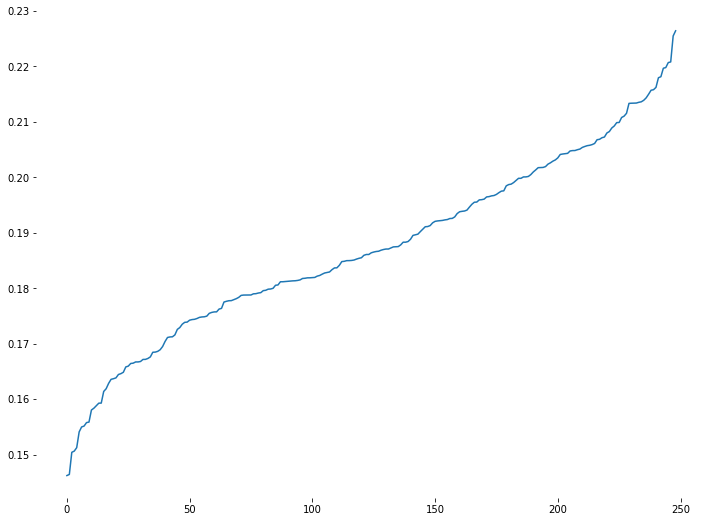

In [22]:
plt.figure(figsize=(12, 9))    
  
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.plot(train_rank[['nom_9_binned','target']].groupby('nom_9_binned').mean().sort_values(by='target').values)
plt.show()

In [23]:
del train
del test

gc.collect()

10723

In [24]:
"""
# create interation variables

group = ['bin_0_binned',
 'bin_1_binned',
 'bin_2_binned',
 'bin_3_binned',
 'bin_4_binned',
 'nom_3_binned',
 'ord_0_binned',
 'ord_1_binned',
 'ord_2_binned',
 'ord_3_binned',
 'ord_4_binned',
 'ord_5_binned',
 'day_binned',
 'month_binned']

import itertools
binned_interaction = []

groups = list(itertools.combinations(group,2))
for f0,f1 in groups:
    
    col = f0+'_'+f1
    print(col)
    
    binned_interaction.append(col)
    
    if col in train_rank.columns and col in test_rank.columns:
        continue
    
    train_rank[col] = train_rank[[f0, f1]].apply(lambda x: str(x[0])+'_'+str(x[1]) ,axis=1)
    test_rank[col] = test_rank[[f0, f1]].apply(lambda x: str(x[0])+'_'+str(x[1]) ,axis=1)
"""
    

"\n# create interation variables\n\ngroup = ['bin_0_binned',\n 'bin_1_binned',\n 'bin_2_binned',\n 'bin_3_binned',\n 'bin_4_binned',\n 'nom_3_binned',\n 'ord_0_binned',\n 'ord_1_binned',\n 'ord_2_binned',\n 'ord_3_binned',\n 'ord_4_binned',\n 'ord_5_binned',\n 'day_binned',\n 'month_binned']\n\nimport itertools\nbinned_interaction = []\n\ngroups = list(itertools.combinations(group,2))\nfor f0,f1 in groups:\n    \n    col = f0+'_'+f1\n    print(col)\n    \n    binned_interaction.append(col)\n    \n    if col in train_rank.columns and col in test_rank.columns:\n        continue\n    \n    train_rank[col] = train_rank[[f0, f1]].apply(lambda x: str(x[0])+'_'+str(x[1]) ,axis=1)\n    test_rank[col] = test_rank[[f0, f1]].apply(lambda x: str(x[0])+'_'+str(x[1]) ,axis=1)\n"

In [25]:
gc.collect()

40

In [26]:
"""
for feature in binned_interaction:
    print(feature)
    feature = [feature]
    rt = RankTransformParallel(dview)

    rdf = distribute_df(train_rank[feature+['target']])

    rt.fit(rdf,features=feature,target='target')

    train_rank[feature] = rt.transform(rdf)[feature]

    rdf = distribute_df(test_rank[feature])

    test_rank[feature] = rt.transform(rdf)[feature]
    
    feature = feature[0]
    bins = np.minimum(train_rank[feature].nunique(),16)
    
    XTRAIN = train_rank[feature].values.flatten().astype(np.float)
    XTEST = test_rank[feature].values.flatten().astype(np.float)
    
    #bin limits based on the test data
    _bins_ = np.linspace(np.min(XTRAIN),np.max(XTRAIN),bins)
    
    XTRAIN = np.digitize(XTRAIN,_bins_)-1
    XTEST = np.digitize(XTEST,_bins_)-1
    
    train_rank[feature] = XTRAIN
    test_rank[feature] = XTEST
"""

"\nfor feature in binned_interaction:\n    print(feature)\n    feature = [feature]\n    rt = RankTransformParallel(dview)\n\n    rdf = distribute_df(train_rank[feature+['target']])\n\n    rt.fit(rdf,features=feature,target='target')\n\n    train_rank[feature] = rt.transform(rdf)[feature]\n\n    rdf = distribute_df(test_rank[feature])\n\n    test_rank[feature] = rt.transform(rdf)[feature]\n    \n    feature = feature[0]\n    bins = np.minimum(train_rank[feature].nunique(),16)\n    \n    XTRAIN = train_rank[feature].values.flatten().astype(np.float)\n    XTEST = test_rank[feature].values.flatten().astype(np.float)\n    \n    #bin limits based on the test data\n    _bins_ = np.linspace(np.min(XTRAIN),np.max(XTRAIN),bins)\n    \n    XTRAIN = np.digitize(XTRAIN,_bins_)-1\n    XTEST = np.digitize(XTEST,_bins_)-1\n    \n    train_rank[feature] = XTRAIN\n    test_rank[feature] = XTEST\n"

In [27]:
gc.collect()

40

In [28]:
train_rank.to_pickle('train_rank_binned_pro')
test_rank.to_pickle('test_rank_binned_pro')

In [29]:
train_rank = pd.read_pickle('train_rank_binned_pro')
test_rank=pd.read_pickle('test_rank_binned_pro')

In [30]:
emb_features = [x for x in train_rank.columns if 'target' not in x and 'id' not in x]

In [31]:
"""
#Find places where the binned interations are not represented in the test dataset
import re
for feature in group:
    print(feature)
    match_re = re.compile(feature)
    reduce = np.array([x for x in binned_interaction if len(match_re.findall(x))>0])
    
    msk = np.any((train_rank.loc[:,reduce]==0).values,axis=1).astype(np.float)
    train_rank.loc[:,feature]=train_rank.loc[:,feature]*msk
    
    msk = np.any((test_rank.loc[:,reduce]==0).values,axis=1).astype(np.float)
    test_rank.loc[:,feature]=test_rank.loc[:,feature]*msk 
"""

'\n#Find places where the binned interations are not represented in the test dataset\nimport re\nfor feature in group:\n    print(feature)\n    match_re = re.compile(feature)\n    reduce = np.array([x for x in binned_interaction if len(match_re.findall(x))>0])\n    \n    msk = np.any((train_rank.loc[:,reduce]==0).values,axis=1).astype(np.float)\n    train_rank.loc[:,feature]=train_rank.loc[:,feature]*msk\n    \n    msk = np.any((test_rank.loc[:,reduce]==0).values,axis=1).astype(np.float)\n    test_rank.loc[:,feature]=test_rank.loc[:,feature]*msk \n'

In [32]:
len(emb_features)

30

In [33]:
"""
#Count of feature interations in the train and test group
no_info_train_msk = np.zeros(train_rank.shape[0],dtype=np.bool)
no_info_test_msk = np.zeros(test_rank.shape[0],dtype=np.bool)

no_info = []
no_info_count = 0
N=0
groups = list(itertools.combinations(['nom_5','nom_6_0'],2))
print(len(groups))
for group in groups:

    group = list(group)
#     group = ['nom_8', 'nom_9']
    percent = train_rank[group+['target']].groupby(group).mean()
    count = train_rank[group+['target']].groupby(group).sum()


    tmp = percent[(percent['target']==1)&(count['target']==1)]

    if tmp.shape[0]>0:
        no_info_count+=tmp.shape[0]
        arr = tmp.reset_index()[group].values

        test_msk = test_rank[group].apply(tuple, axis = 1).isin(tuple(map(tuple, arr)))
        train_msk = train_rank[group].apply(tuple, axis = 1).isin(tuple(map(tuple, arr)))
        no_info_test_msk=no_info_test_msk|test_msk
        no_info_train_msk=no_info_train_msk|train_msk
        print('_'.join(group))
        print(np.sum(train_msk),np.sum(test_msk),N)

        no_info.append([group,tuple(map(tuple, arr)),train_msk,test_msk])
    N+=1
"""

"\n#Count of feature interations in the train and test group\nno_info_train_msk = np.zeros(train_rank.shape[0],dtype=np.bool)\nno_info_test_msk = np.zeros(test_rank.shape[0],dtype=np.bool)\n\nno_info = []\nno_info_count = 0\nN=0\ngroups = list(itertools.combinations(['nom_5','nom_6_0'],2))\nprint(len(groups))\nfor group in groups:\n\n    group = list(group)\n#     group = ['nom_8', 'nom_9']\n    percent = train_rank[group+['target']].groupby(group).mean()\n    count = train_rank[group+['target']].groupby(group).sum()\n\n\n    tmp = percent[(percent['target']==1)&(count['target']==1)]\n\n    if tmp.shape[0]>0:\n        no_info_count+=tmp.shape[0]\n        arr = tmp.reset_index()[group].values\n\n        test_msk = test_rank[group].apply(tuple, axis = 1).isin(tuple(map(tuple, arr)))\n        train_msk = train_rank[group].apply(tuple, axis = 1).isin(tuple(map(tuple, arr)))\n        no_info_test_msk=no_info_test_msk|test_msk\n        no_info_train_msk=no_info_train_msk|train_msk\n        p

In [34]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [35]:
import tensorflow as tf
import pickle


In [36]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_,df_.index.values

In [37]:
train_rank['target_0']=train_rank['target']==0
train_rank['target_1']=train_rank['target']==1

In [38]:
train_rank.reset_index(drop=True,inplace=True)
test_rank.reset_index(drop=True,inplace=True)

In [39]:
gc.collect()

62

In [40]:
class CatEmbeddingBlock(tf.keras.Model):
    def __init__(self,n_uniq,embed_dim):
        super(CatEmbeddingBlock,self).__init__(name='')
        self.emb = tf.keras.layers.Embedding(n_uniq + 1, embed_dim)
        self.drop = tf.keras.layers.SpatialDropout1D(0.1)
        self.out = tf.keras.layers.Reshape(target_shape=(embed_dim, ))
            
    def call(self,input_data,training=False):

        emb = self.emb(input_data)
        drop = self.drop(emb)
        out = self.out(drop)

        return out

In [41]:
emb_features = [x for x in train_rank.columns if 'target' not in x and 'id' not in x]

In [42]:
emb_features = np.array(emb_features)

In [43]:
np.mkl.set_num_threads(6)
tf.keras.backend.clear_session()

In [44]:
import tensorflow as tf
inputs = []
embed_layers = []
embed_dims = []
num_unique_values = []
for i in range(train_rank[emb_features].shape[1]):
    print(i)
    inp = tf.keras.layers.Input(shape=(1,))
    
    n_uniq = np.max(train_rank[emb_features].values[:,i]).astype(np.int)
#     embed_dim = int(min(np.ceil((n_uniq)/2), 32))
    embed_dim = int(min(n_uniq, 32))
    
    layer = CatEmbeddingBlock(n_uniq,embed_dim)(inp)
    
    
    inputs.append(inp)
    embed_layers.append(layer)
    
    embed_dims.append(embed_dim)
    num_unique_values.append(n_uniq)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [45]:
test_rank.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'isnan',
       'id', 'nom_5_binned', 'nom_6_binned', 'nom_9_binned', 'nom_7_binned',
       'nom_8_binned', 'ord_5_binned'],
      dtype='object')

In [46]:
D = len(emb_features)

In [47]:
D

30

In [48]:
# raw_input = tf.keras.Input(shape=(D))
# e = tf.keras.layers.Concatenate()(embed_layers+[raw_input])

e = tf.keras.layers.Concatenate()(embed_layers)
e = tf.keras.layers.BatchNormalization()(e)
e = tf.keras.layers.Dense(300, activation="relu")(e)
e = tf.keras.layers.Dropout(0.3)(e)
e = tf.keras.layers.BatchNormalization()(e)
e = tf.keras.layers.Dense(300, activation="relu")(e)
e = tf.keras.layers.Dropout(0.3)(e)
e = tf.keras.layers.BatchNormalization()(e)


output = tf.keras.layers.Dense(2, activation="softmax")(e)

In [49]:
# model = tf.keras.Model(inputs+[raw_input], output)
model = tf.keras.Model(inputs, output)

# concat_layers.shape

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy',tf.keras.metrics.AUC()])

In [50]:
init_W = model.get_weights()

In [51]:

train_rank['target_0']=train_rank['target']==0
train_rank['target_1']=train_rank['target']==1

In [52]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_.index.values

In [61]:
from sklearn import model_selection

W = []

submission = test_rank[['id']]
submission['target'] = 0

for run in range(3):

    df_indx = stratified_sample_df(train_rank,'target',112323)


    kf = model_selection.KFold(n_splits=8,shuffle=True)

    for train_index, test_index in kf.split(df_indx):

        model.set_weights(init_W)

        trainidx = df_indx[train_index]
        testidx = df_indx[test_index]

        EMBTRAIN = [train_rank.loc[trainidx,emb_features[k]].values for k in range(D)]
#         EMBTRAIN+=[train_rank.loc[trainidx,emb_features].values]

        EMBTEST = [train_rank.loc[testidx,emb_features[k]].values for k in range(D)]
#         EMBTEST+=[train_rank.loc[testidx,emb_features].values]

        YTRAIN = train_rank.loc[trainidx,['target_0','target_1']].values
        YTEST = train_rank.loc[testidx,['target_0','target_1']].values

        print('done creating data')


        es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=0.0001, patience=5,
                                     verbose=1, mode='max', baseline=None, restore_best_weights=True)

        rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                          patience=3, min_lr=1e-3, mode='max', verbose=1)


        model.fit(EMBTRAIN,
                  YTRAIN,
                  validation_data=(EMBTEST, YTEST),
                  verbose=1,
                  batch_size=256,
                  callbacks=[es, rlr],
                  epochs=100,
                 )


        XTEST = [test_rank[emb_features[k]].values.astype(np.float32) for k in range(D)]
#         XTEST+=[test_rank.loc[:,emb_features].values.astype(np.float32)]

        ypred_test = model.predict(XTEST, batch_size=100,workers=6)

        submission['target'] += ypred_test[:,1]
        print()
        gc.collect()

        W.append(model.get_weights())

/Users/rohankotwani/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


done creating data
Train on 196565 samples, validate on 28081 samples
Epoch 1/100
196565/196565 [==============================] - 12s 60us/sample - loss: 0.5989 - accuracy: 0.6858 - auc: 0.7496 - val_loss: 0.5573 - val_accuracy: 0.7080 - val_auc: 0.7843
Epoch 2/100
196565/196565 [==============================] - 12s 59us/sample - loss: 0.5559 - accuracy: 0.7134 - auc: 0.7869 - val_loss: 0.5569 - val_accuracy: 0.7123 - val_auc: 0.7858
Epoch 3/100
196565/196565 [==============================] - 12s 59us/sample - loss: 0.5479 - accuracy: 0.7187 - auc: 0.7942 - val_loss: 0.5590 - val_accuracy: 0.7117 - val_auc: 0.7836
Epoch 4/100
196565/196565 [==============================] - 12s 59us/sample - loss: 0.5394 - accuracy: 0.7255 - auc: 0.8017 - val_loss: 0.5608 - val_accuracy: 0.7068 - val_auc: 0.7819
Epoch 5/100
195584/196565 [============================>.] - ETA: 0s - loss: 0.5277 - accuracy: 0.7333 - auc: 0.8120
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.001.
196565/19

/Users/rohankotwani/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



done creating data
Train on 196565 samples, validate on 28081 samples
Epoch 1/100
196565/196565 [==============================] - 12s 62us/sample - loss: 0.5957 - accuracy: 0.6867 - auc: 0.7520 - val_loss: 0.5641 - val_accuracy: 0.7039 - val_auc: 0.7778
Epoch 2/100
196565/196565 [==============================] - 12s 61us/sample - loss: 0.5559 - accuracy: 0.7131 - auc: 0.7867 - val_loss: 0.5623 - val_accuracy: 0.7059 - val_auc: 0.7797
Epoch 3/100
196565/196565 [==============================] - 13s 65us/sample - loss: 0.5470 - accuracy: 0.7200 - auc: 0.7951 - val_loss: 0.5638 - val_accuracy: 0.7057 - val_auc: 0.7784
Epoch 4/100
196565/196565 [==============================] - 12s 62us/sample - loss: 0.5385 - accuracy: 0.7256 - auc: 0.8024 - val_loss: 0.5674 - val_accuracy: 0.7023 - val_auc: 0.7751
Epoch 5/100
195584/196565 [============================>.] - ETA: 0s - loss: 0.5272 - accuracy: 0.7339 - auc: 0.8124
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.001.
196565/1

Epoch 00007: early stopping

done creating data
Train on 196566 samples, validate on 28080 samples
Epoch 1/100
196566/196566 [==============================] - 12s 62us/sample - loss: 0.5962 - accuracy: 0.6873 - auc: 0.7517 - val_loss: 0.5554 - val_accuracy: 0.7101 - val_auc: 0.7870
Epoch 2/100
196566/196566 [==============================] - 12s 60us/sample - loss: 0.5562 - accuracy: 0.7129 - auc: 0.7865 - val_loss: 0.5550 - val_accuracy: 0.7112 - val_auc: 0.7872
Epoch 3/100
196566/196566 [==============================] - 12s 61us/sample - loss: 0.5478 - accuracy: 0.7186 - auc: 0.7941 - val_loss: 0.5585 - val_accuracy: 0.7104 - val_auc: 0.7852
Epoch 4/100
196566/196566 [==============================] - 13s 66us/sample - loss: 0.5399 - accuracy: 0.7234 - auc: 0.8012 - val_loss: 0.5604 - val_accuracy: 0.7098 - val_auc: 0.7841
Epoch 5/100
196352/196566 [============================>.] - ETA: 0s - loss: 0.5289 - accuracy: 0.7324 - auc: 0.8110
Epoch 00005: ReduceLROnPlateau reducing lear

196565/196565 [==============================] - 12s 64us/sample - loss: 0.5070 - accuracy: 0.7485 - auc: 0.8291 - val_loss: 0.5894 - val_accuracy: 0.6962 - val_auc: 0.7649
Epoch 7/100
196565/196565 [==============================] - 12s 61us/sample - loss: 0.4815 - accuracy: 0.7657 - auc: 0.8482 - val_loss: 0.6106 - val_accuracy: 0.6866 - val_auc: 0.7535
Epoch 00007: early stopping

done creating data
Train on 196565 samples, validate on 28081 samples
Epoch 1/100
196565/196565 [==============================] - 12s 60us/sample - loss: 0.5963 - accuracy: 0.6862 - auc: 0.7513 - val_loss: 0.5625 - val_accuracy: 0.7093 - val_auc: 0.7840
Epoch 2/100
196565/196565 [==============================] - 12s 59us/sample - loss: 0.5563 - accuracy: 0.7126 - auc: 0.7863 - val_loss: 0.5563 - val_accuracy: 0.7106 - val_auc: 0.7862
Epoch 3/100
196565/196565 [==============================] - 12s 61us/sample - loss: 0.5481 - accuracy: 0.7191 - auc: 0.7940 - val_loss: 0.5593 - val_accuracy: 0.7100 - val_

Epoch 6/100
196566/196566 [==============================] - 12s 59us/sample - loss: 0.5100 - accuracy: 0.7467 - auc: 0.8267 - val_loss: 0.5841 - val_accuracy: 0.6959 - val_auc: 0.7686
Epoch 7/100
196566/196566 [==============================] - 12s 59us/sample - loss: 0.4855 - accuracy: 0.7631 - auc: 0.8456 - val_loss: 0.6003 - val_accuracy: 0.6898 - val_auc: 0.7582
Epoch 00007: early stopping

done creating data
Train on 196565 samples, validate on 28081 samples
Epoch 1/100
196565/196565 [==============================] - 12s 60us/sample - loss: 0.5986 - accuracy: 0.6847 - auc: 0.7489 - val_loss: 0.5610 - val_accuracy: 0.7079 - val_auc: 0.7815
Epoch 2/100
196565/196565 [==============================] - 12s 60us/sample - loss: 0.5578 - accuracy: 0.7113 - auc: 0.7848 - val_loss: 0.5601 - val_accuracy: 0.7098 - val_auc: 0.7830
Epoch 3/100
196565/196565 [==============================] - 12s 60us/sample - loss: 0.5487 - accuracy: 0.7182 - auc: 0.7931 - val_loss: 0.5637 - val_accuracy: 0

196565/196565 [==============================] - 12s 60us/sample - loss: 0.5503 - accuracy: 0.7176 - auc: 0.7922 - val_loss: 0.5605 - val_accuracy: 0.7081 - val_auc: 0.7819
Epoch 4/100
196565/196565 [==============================] - 12s 60us/sample - loss: 0.5419 - accuracy: 0.7220 - auc: 0.7994 - val_loss: 0.5637 - val_accuracy: 0.7047 - val_auc: 0.7796
Epoch 5/100
195840/196565 [============================>.] - ETA: 0s - loss: 0.5309 - accuracy: 0.7306 - auc: 0.8091
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.001.
196565/196565 [==============================] - 12s 59us/sample - loss: 0.5310 - accuracy: 0.7305 - auc: 0.8090 - val_loss: 0.5692 - val_accuracy: 0.7029 - val_auc: 0.7741
Epoch 6/100
196565/196565 [==============================] - 12s 59us/sample - loss: 0.5125 - accuracy: 0.7442 - auc: 0.8247 - val_loss: 0.5785 - val_accuracy: 0.6972 - val_auc: 0.7677
Epoch 7/100
196565/196565 [==============================] - 12s 60us/sample - loss: 0.4877 - accuracy:

In [63]:
submission.target=submission.target/24

In [64]:
submission.to_csv('submission.csv',index=False)

In [65]:
submission

,id,target
0,600000,0.392636
1,600001,0.585291
2,600002,0.469941
3,600003,0.430713
4,600004,0.404220
...,...,...
399995,999995,0.861663
399996,999996,0.825350
399997,999997,0.831648
399998,999998,0.633191
